<a href="https://colab.research.google.com/github/diegoestradaXO/Proyecto2-Data-Science/blob/master/Proyecto_2_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto 2: Data Science
### Detección de COVID-19 en radiografías de tórax

### Objetivos
- General
  - Identificar y localizar anomalías causadas por COVID-19 en radiografías de tórax
- Secundarios:
  - Generar modelos y predicciones sobre las anomalías causadas por COVID-19 con el uso de Data Science, haciendo uso de las técnicas de filtrado y procesamiento de imágenes 
  - Agilizar el proceso de detección de COVID-19, identificando patrones intersticiales por medio del análisis de imágenes de radiografías de tórax.
Etiquetar las imágenes de radiografías de tórax por; negativo a neumonía, apariencia típica, indeterminada o atípica.


### Autores:

Andrea Elías - 17048<br>
Diego Estrada - 18540<br>
Saúl Contreras - 18409 <br>
Randy Venegas - 18341

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
pip install pydicom

     |████████████████████████████████| 2.0 MB 9.4 MB/s 


In [ ]:
import pandas as pd
import os
import math
from PIL import Image
import cv2
import numpy as np
import sys 
import matplotlib.pyplot as plt
import pydicom

from pandas import DataFrame

from matplotlib.lines import Line2D
import seaborn as sns
import plotly.express as px

import pydicom
import glob
import cv2

from tqdm.notebook import tqdm
from pydicom.pixel_data_handlers.util import apply_voi_lut
from skimage import exposure

In [ ]:
data_study_level = pd.read_csv('/content/drive/My Drive/datasets/siim-covid-19/train_study_level.csv')

In [ ]:
data_image_level = pd.read_csv('/content/drive/My Drive/datasets/siim-covid-19/train_image_level.csv')

El shape establece cuantos datos contiene el conjunto, y cuantas columnas posee. Para el caso del conjunto de datos de nivel de imagen, hay 6334 filas y 4 columnas.

In [ ]:
data_image_level.shape


(6334, 4)

Para el conjunto de datos a nivel de estudio, se observa que se cuenta con 6054 filas y 5 columnas

In [ ]:
data_study_level.shape


(6054, 5)

A continuación se presentan las cinco columnas y primeras cinco filas del dataset a nivel de estudio.

In [ ]:
data_study_level.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


A continuación se presentan las cinco columnas y primeras cinco filas del dataset a nivel de imagen.

In [ ]:
data_image_level.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


## Study level

El nivel de estudio es un problema de clasificación, una radiografía puede tener una de las 
4 clases siguientes: 
Negativo: Sin COVID, pulmones limpios,
Típicos: Hallazgos comunes en COVID-19,
Atípico: Hallazgos poco frecuentes en COVID-19,
Indeterminado: Los hallazgos que se encontraron suelen ser comunes en COVID-19, pero también se observa en otra infecciones respiratorias


Calcular la variable class que identificará a que clase de las descritas anteriormente 
mencionadas. 


In [ ]:
data_study_level['class'] = 'Typical'
data_study_level.loc[data_study_level['Negative for Pneumonia']==1, 'class'] = 'Negative'
data_study_level.loc[data_study_level['Indeterminate Appearance']==1, 'class'] = 'Indeterminate'
data_study_level.loc[data_study_level['Atypical Appearance']==1, 'class'] = 'Atypical'

data_study_level.head(3)

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,study_class,StudyInstanceUID,class
0,00086460a852_study,0,1,0,0,Typical,00086460a852,Typical
1,000c9c05fd14_study,0,0,0,1,Atypical,000c9c05fd14,Atypical
2,00292f8c37bd_study,1,0,0,0,Negative,00292f8c37bd,Negative


Determinar la frecuencia de cada clase

In [ ]:
data_study_level.groupby(['class']).size().reset_index(name='counts')

,class,counts
0,Atypical,474
1,Indeterminate,1049
2,Negative,1676
3,Typical,2855


Gráfica de barras con las frecuencias y clases


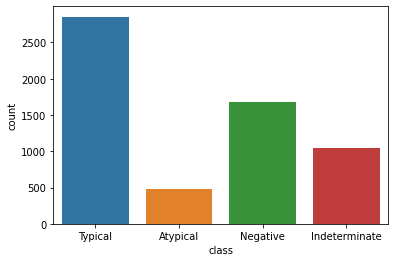

In [ ]:
import seaborn as sns

ax = sns.countplot(x="class",data=data_study_level)

Se observa que la clase de apariencia típica predomina frente a las otras 3 clases.

## Image Level

Una  radiografía  puede  tener  cualquiera  de  las  dos  clases  siguientes  en función de 
los cuadros delimitadores o no. Puede haber 0 o más información de cuadro delimitador
para cada imagen, dada en formato x1, y1, W, H para cada cuadro.

none: para las imágenes que no tienen información de cuadro delimitador 
(normalmente, que también son negativas a nivel de estudio).
opacidad: para las imágenes que tienen cuadros delimitadores, tienen "opacidad" 
a nivel de imagen. 



Calcular la variable “class” que identificará a que clase de las descritas anteriormente mencionadas. 


In [ ]:
data_image_level['class'] = data_image_level.label.apply(lambda x: x.split()[0])

Determinar la frecuencia de las clase

In [ ]:
data_image_level.groupby(['class']).size().reset_index(name='counts')

,class,counts
0,none,2040
1,opacity,4294


Gráfica de barras con las frecuencias y clases

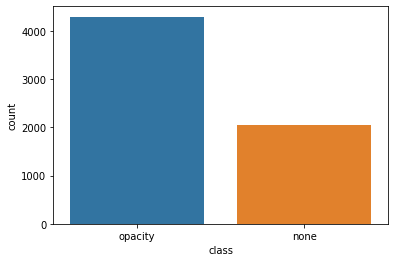

In [ ]:
ax = sns.countplot(x="class",data=data_image_level)

### Unir ambos datasets

In [ ]:
data_study_level['StudyInstanceUID'] = data_study_level['id'].apply(lambda x: x.replace('_study', ''))
train_df = data_image_level.merge(data_image_level, on='StudyInstanceUID')
train_df.sample(3)

,id_x,boxes_x,label_x,StudyInstanceUID,class_x,id_y,boxes_y,label_y,class_y
3466,6ea6f1a79e68_image,"[{'x': 271.38756, 'y': 674.07467, 'width': 591...",opacity 1 271.38756 674.07467 863.01244 1599.5...,0ba072188224,opacity,6ea6f1a79e68_image,"[{'x': 271.38756, 'y': 674.07467, 'width': 591...",opacity 1 271.38756 674.07467 863.01244 1599.5...,opacity
5850,cabdf7ef7881_image,"[{'x': 2050.10644, 'y': 1100.21282, 'width': 5...",opacity 1 2050.10644 1100.21282 2611.57202 167...,65442563a7ae,opacity,cabdf7ef7881_image,"[{'x': 2050.10644, 'y': 1100.21282, 'width': 5...",opacity 1 2050.10644 1100.21282 2611.57202 167...,opacity
5655,c3c012779959_image,NaN,none 1 0 0 1 1,ba401a51fdee,none,c3c012779959_image,NaN,none 1 0 0 1 1,none
